In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler
)

from sklearn.dummy import DummyRegressor

## Predicting Breast Cancer Diagnosis Using Cell Nuclei Morphology

This project will focus on building and assessing a machine-learning model that can determine the diagnosis (Malignant or Benign) based on the characteristics of cell nuclei. The dataset was obtained from the Diagnostic Wisconsin Breast Cancer Database and downloaded through Kaggle. The cell nuclei were observed using fine needle aspirate (FNA) of breast mass. 

The dataset includes features for radius, texture, perimeter, area, smoothness, compactness, concavity, concave points, symmetry and fractal dimension. For each feature, the mean, standard error and worst/largest value were documented in separate columns. Malignant cell nuclei typically exhibit larger size and irregular shape, changes can also occur to the surface, volume, density, structure and homogeneity ([Link](https://www.ncbi.nlm.nih.gov/books/NBK9553/)). Previous findings have linked the identification of cell morphology to risk of metastasis and tumorigenicity ([Link](https://breast-cancer-research.biomedcentral.com/articles/10.1186/s13058-024-01796-8)) which facilitates widespread cancerous invasions to other organs such as bones, lungs, liver and brain ([Link](https://www.sciencedirect.com/science/article/pii/S1044579X1930063X#sec0010)).

This model will be trained on cell nuclei morphology to diagnose infections as malignant or benign using classification-supervised machine learning. It can be used as a tool to efficiently classify samples. It will also highlight the most important features that contribute to the diagnosis, thereby enhancing the interpretability of the output. 



In [3]:
breast_cancer = pd.read_csv("data/breast-cancer-wisconsin.csv")
breast_cancer.head(10)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN
5,843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,NaN
6,844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,NaN
7,84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,NaN
8,844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,NaN
9,84501001,M,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,NaN


Malignant Cases: 212, 37.26 %
Benign Cases: 357, 62.74 %


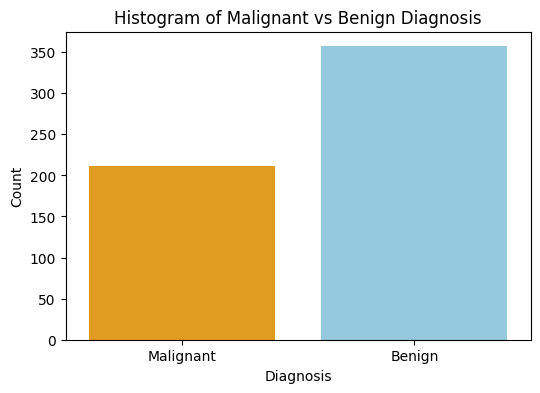

In [39]:
malignant_count = len(breast_cancer[breast_cancer["diagnosis"] == "M"])
benign_count = len(breast_cancer[breast_cancer["diagnosis"] == "B"])
print(f"Malignant Cases: {malignant_count}, {malignant_count/len(breast_cancer)*100:.2f} %")
print(f"Benign Cases: {benign_count}, {benign_count/len(breast_cancer)*100:.2f} %")

plt.figure(figsize=(6,4))
sns.countplot(x = 'diagnosis', 
              data=breast_cancer, 
              
              hue='diagnosis', 
              palette={'M': 'orange', 'B': 'skyblue'})
plt.title("Histogram of Malignant vs Benign Diagnosis")
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(ticks = ['M', 'B'], labels=['Malignant', 'Benign'])
plt.show()

### Intial Observations of the Dataset: 
- There are no missing values, imputation is not required.
- There may be highly correlated features in the dataset due to each observation containing the mean, standard error and worst value. This could potentially cause issues due to redundancy and multicolinearity (for linear models).
- There are more examples with benign diagnosis than malignant, but the difference is not extreme. 
- There is an extra column (feature #32) that does not contain any data, requires removal.
- All features of integer/float data types


In [5]:
breast_cancer = breast_cancer.drop(columns = ["id", "Unnamed: 32"])
X = breast_cancer.drop(columns=["diagnosis"])
y = breast_cancer["diagnosis"]

X_train, y_train, X_test, y_test = train_test_split(X, y, train_size = 0.7, random_state=123)

### Exploratory Data Analysis (EDA)

In [6]:
X_train_mean = X_train.filter(like="_mean")
X_train_se = X_train.filter(like="_se")
X_train_worst = X_train.filter(like="_worst")

Used the **describe** function to observe summary statistics on the columns showing the mean and worst values. The results indicate there is substantial variation between features, the dataset requires normalization. In particular, the area feature contains min/max values that vary largely outside the 25%-75% (IQR) range. Standard deviation is consistently lower than the mean, suggesting variation is controlled. 

In [14]:
X_train_mean.describe().T

,count,mean,std,min,25%,50%,75%,max
radius_mean,398.0,14.144759,3.496451,7.69100,11.602500,13.515000,16.027500,27.42000
texture_mean,398.0,19.403593,4.458139,10.38000,16.187500,18.900000,21.892500,39.28000
perimeter_mean,398.0,92.078266,24.040299,47.92000,74.385000,87.295000,105.000000,186.90000
area_mean,398.0,655.813065,344.815080,170.40000,412.525000,561.700000,796.650000,2501.00000
smoothness_mean,398.0,0.095989,0.013831,0.05263,0.085977,0.095150,0.104575,0.16340
compactness_mean,398.0,0.104524,0.052519,0.02650,0.066090,0.093020,0.129700,0.34540
concavity_mean,398.0,0.089133,0.080020,0.00000,0.029950,0.062650,0.122400,0.42680
concave points_mean,398.0,0.049081,0.038360,0.00000,0.020715,0.033455,0.073850,0.20120
symmetry_mean,398.0,0.181156,0.028975,0.10600,0.160300,0.178300,0.196000,0.30400
fractal_dimension_mean,398.0,0.062798,0.007392,0.04996,0.057563,0.061400,0.066195,0.09744


<Axes: xlabel='fractal_dimension_mean'>

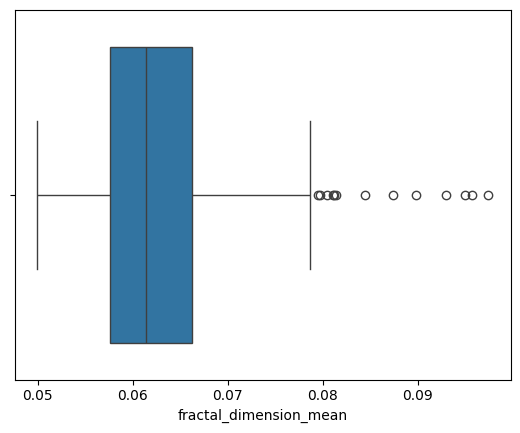

In [46]:
sns.boxplot(x=X_train_mean['fractal_dimension_mean'])

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
radius_mean,1.000000,0.321228,0.997642,0.988027,0.154851,0.472330,0.635485,0.805707,0.147802,-0.332348
texture_mean,0.321228,1.000000,0.325717,0.323979,-0.060214,0.188772,0.278484,0.274815,0.006971,-0.105683
perimeter_mean,0.997642,0.325717,1.000000,0.987225,0.192891,0.527183,0.678126,0.836756,0.184758,-0.279731
area_mean,0.988027,0.323979,0.987225,1.000000,0.162563,0.472110,0.650498,0.811260,0.157053,-0.303230
smoothness_mean,0.154851,-0.060214,0.192891,0.162563,1.000000,0.663361,0.515249,0.548292,0.555035,0.573192
compactness_mean,0.472330,0.188772,0.527183,0.472110,0.663361,1.000000,0.881399,0.825734,0.608899,0.584233
concavity_mean,0.635485,0.278484,0.678126,0.650498,0.515249,0.881399,1.000000,0.908753,0.516095,0.366919
concave points_mean,0.805707,0.274815,0.836756,0.811260,0.548292,0.825734,0.908753,1.000000,0.480018,0.171774
symmetry_mean,0.147802,0.006971,0.184758,0.157053,0.555035,0.608899,0.516095,0.480018,1.000000,0.475101
fractal_dimension_mean,-0.332348,-0.105683,-0.279731,-0.303230,0.573192,0.584233,0.366919,0.171774,0.475101,1.000000


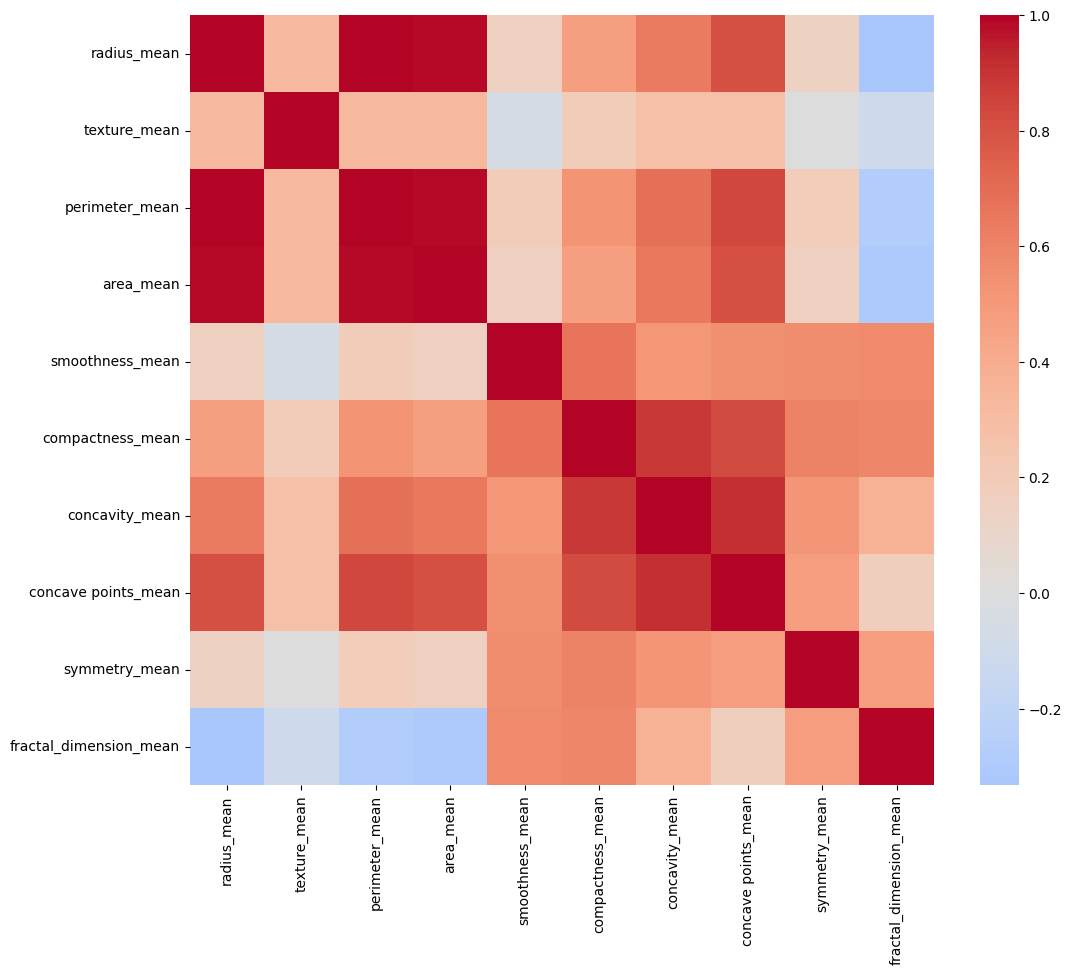

In [47]:
plt.figure(figsize=(12,10))
c = X_train_mean.corr()
sns.heatmap(c,cmap="coolwarm",center=0)
c

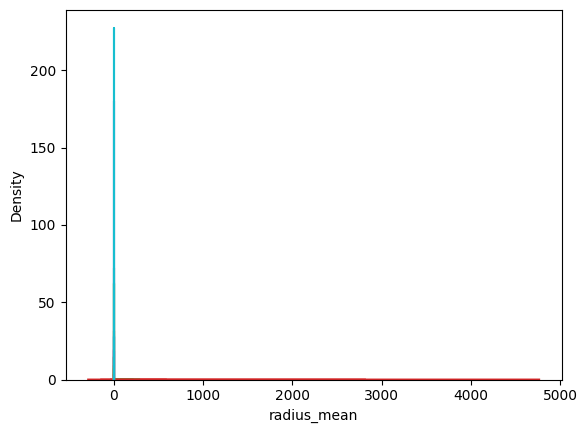

In [30]:
for col in X_train.columns:
    sns.kdeplot(X_train[col], label=col)

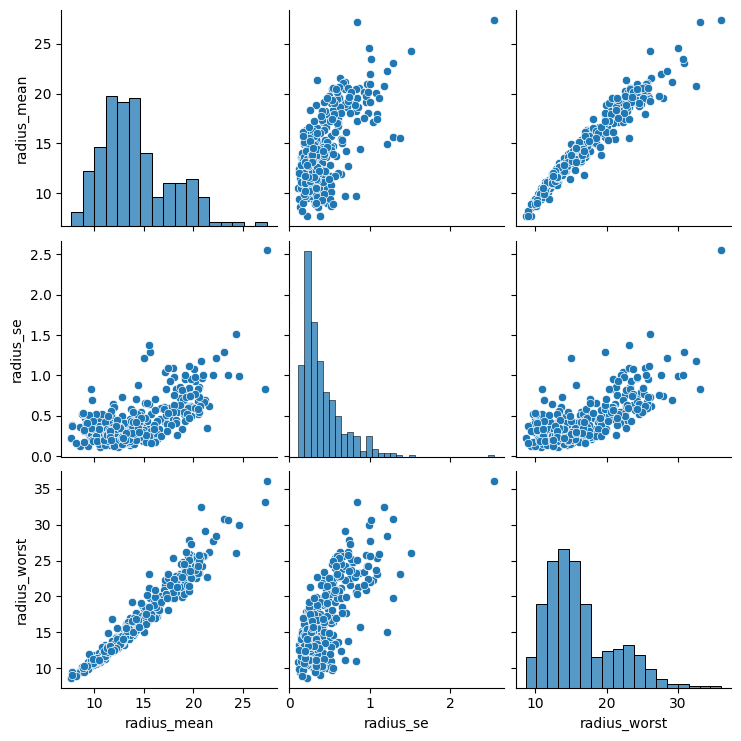

In [31]:
sns.pairplot(X_train[["radius_mean", "radius_se", "radius_worst"]])